In [1]:
from google.colab import drive
drive.mount('/content/mydrive_mount', force_remount=True)


Mounted at /content/mydrive_mount


Loading and Balancing Dataset

In [2]:
# Step 1: Install kaggle CLI if not already
!pip install -q kaggle

# Step 2: Upload the correct kaggle.json file
from google.colab import files
uploaded = files.upload()  # ← make sure you upload your real kaggle.json here


Saving kaggle.json to kaggle (4).json


In [3]:
import shutil
import os

# Replace with correct path after using os.listdir()
source_path = "/content/kaggle.json"
target_path = os.path.expanduser("~/.kaggle/kaggle.json")

os.makedirs(os.path.dirname(target_path), exist_ok=True)
shutil.copy(source_path, target_path)
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tanlikesmath/diabetic-retinopathy-resized")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/diabetic-retinopathy-resized


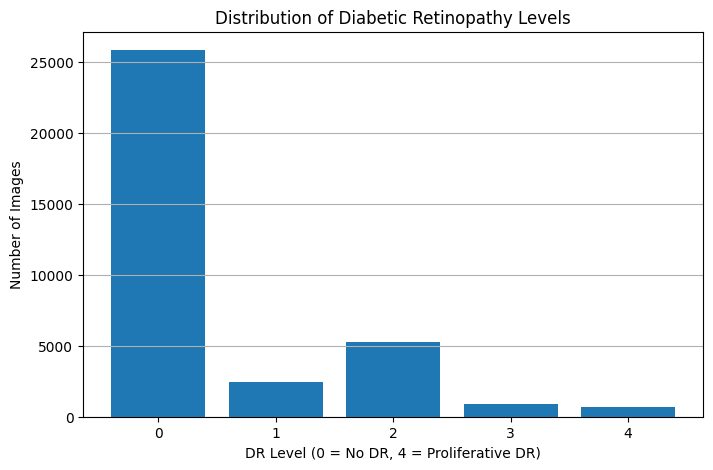

In [5]:
import pandas as pd
import matplotlib.pyplot as plt


labels_path = os.path.join(path, "trainLabels.csv")
df = pd.read_csv(labels_path)


# Count occurrences of each class level
class_counts = df['level'].value_counts().sort_index()

# Plot class distribution
plt.figure(figsize=(8, 5))
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.title("Distribution of Diabetic Retinopathy Levels")
plt.xlabel("DR Level (0 = No DR, 4 = Proliferative DR)")
plt.ylabel("Number of Images")
plt.grid(axis='y')
plt.show()


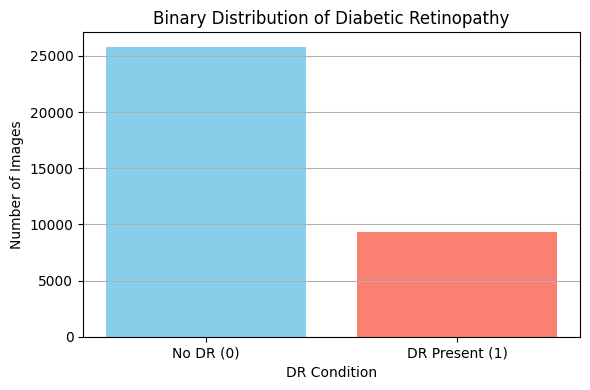

   DR Condition (0=No DR, 1=DR Present)  Number of Images
0                                     0             25810
1                                     1              9316


In [6]:
import pandas as pd
import matplotlib.pyplot as plt


labels_path = os.path.join(path, "trainLabels.csv")
df = pd.read_csv(labels_path)


# Combine classes 1, 2, 3, 4 into class 1 ("DR Present")
df['binary_level'] = df['level'].apply(lambda x: 0 if x == 0 else 1)

# Count the binary classes
binary_counts = df['binary_level'].value_counts().sort_index()

# Plot the binary distribution
plt.figure(figsize=(6, 4))
plt.bar(binary_counts.index.astype(str), binary_counts.values, color=['skyblue', 'salmon'])
plt.xticks(ticks=[0, 1], labels=['No DR (0)', 'DR Present (1)'])
plt.title("Binary Distribution of Diabetic Retinopathy")
plt.xlabel("DR Condition")
plt.ylabel("Number of Images")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Optional: Display the distribution as a DataFrame
binary_counts_df = binary_counts.reset_index()
binary_counts_df.columns = ['DR Condition (0=No DR, 1=DR Present)', 'Number of Images']
print(binary_counts_df)


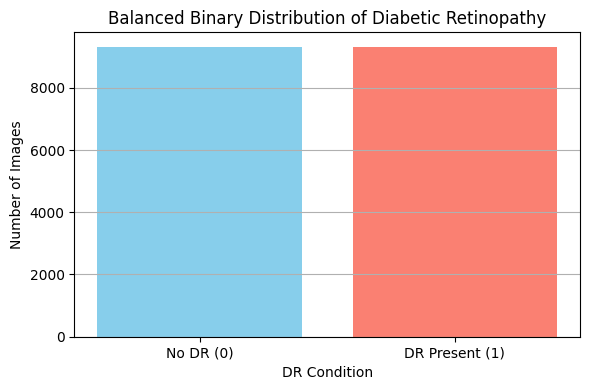

             image  level  binary_level
8949   11228_right      0             0
2670     3333_left      0             0
18020   22702_left      0             0
27733  35092_right      2             1
2123    2641_right      0             0


In [7]:
import pandas as pd
import matplotlib.pyplot as plt



labels_path = os.path.join(path, "trainLabels.csv")
df = pd.read_csv(labels_path)

# Convert to binary
df['binary_level'] = df['level'].apply(lambda x: 0 if x == 0 else 1)

# Separate the classes
df_0 = df[df['binary_level'] == 0]
df_1 = df[df['binary_level'] == 1]

# Downsample class 0 to match class 1 count
df_0_balanced = df_0.sample(n=len(df_1), random_state=42)

# Combine balanced classes
df_balanced = pd.concat([df_0_balanced, df_1], axis=0).sample(frac=1, random_state=42)  # shuffle

# Confirm new distribution
balanced_counts = df_balanced['binary_level'].value_counts().sort_index()

# Plot
plt.figure(figsize=(6, 4))
plt.bar(balanced_counts.index.astype(str), balanced_counts.values, color=['skyblue', 'salmon'])
plt.xticks(ticks=[0, 1], labels=['No DR (0)', 'DR Present (1)'])
plt.title("Balanced Binary Distribution of Diabetic Retinopathy")
plt.xlabel("DR Condition")
plt.ylabel("Number of Images")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Optional: Save or inspect df_balanced
print(df_balanced.head())


In [8]:
# Save to CSV (without the index)
df_balanced.to_csv("balanced_trainLabels.csv", index=False)
df_balanced.to_csv("/content/drive/MyDrive/EECE 490 Project/balanced_trainLabels.csv", index=False)


In [9]:
import os
import shutil
from tqdm import tqdm

# ✅ Set correct dynamic source folder path
source_folder = os.path.join(path, "resized_train", "resized_train")
destination_folder = "/content/drive/MyDrive/EECE 490 Project/Balanced_Dataset"
os.makedirs(destination_folder, exist_ok=True)

copied = 0
for img_id in tqdm(df_balanced['image']):
    src_path = os.path.join(source_folder, f"{img_id}.jpeg")
    dst_path = os.path.join(destination_folder, f"{img_id}.jpeg")
    if os.path.exists(src_path):
        shutil.copyfile(src_path, dst_path)
        copied += 1

print(f"✅ Done copying {copied} images.")


100%|██████████| 18632/18632 [00:35<00:00, 528.52it/s]

✅ Done copying 18632 images.


In [10]:
import os

input_folder = "/content/drive/MyDrive/EECE 490 Project/Balanced_Dataset"
all_files = os.listdir(input_folder)
jpeg_files = [f for f in all_files if f.endswith(".jpeg")]

print(f"Total files in folder: {len(all_files)}")
print(f"JPEG files found: {len(jpeg_files)}")
print("Sample files:", jpeg_files[:5])


Total files in folder: 18632
JPEG files found: 18632
Sample files: ['3682_right.jpeg', '16238_right.jpeg', '42473_left.jpeg', '6837_right.jpeg', '30468_right.jpeg']


**Preprocessing**

1- Crop Retina & Resize

In [45]:
import cv2
import numpy as np

def crop_retina_circle(img, resize_to=(512, 512)):
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            raise ValueError("No retina contour found")

        largest_contour = max(contours, key=cv2.contourArea)
        (x, y), radius = cv2.minEnclosingCircle(largest_contour)
        x, y, radius = int(x), int(y), int(radius)

        x1, y1 = max(0, x - radius), max(0, y - radius)
        x2, y2 = min(img.shape[1], x + radius), min(img.shape[0], y + radius)
        cropped = img[y1:y2, x1:x2]

        if cropped is None or cropped.size == 0:
            raise ValueError("Image is empty after cropping")

        # Resize to target
        cropped_resized = cv2.resize(cropped, resize_to)

        # === Apply circular mask ===
        mask = np.zeros((resize_to[1], resize_to[0]), dtype=np.uint8)
        cv2.circle(mask, (resize_to[0] // 2, resize_to[1] // 2), resize_to[0] // 2, 255, -1)
        masked = cv2.bitwise_and(cropped_resized, cropped_resized, mask=mask)

        return masked

    except Exception as e:
        print(f"⚠️ Crop failed: {e}")
        return None


⚠️ Crop failed: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


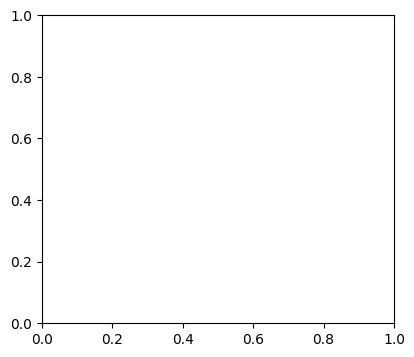

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Path to one image from balanced set
img_path = "/content/drive/MyDrive/EECE 490 Project/Balanced_Dataset/10_left.jpeg"
img = cv2.imread(img_path)

processed_img = crop_retina_circle(img)

# Show before and after
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
plt.title("Cropped + Resized")
plt.axis("off")
plt.tight_layout()
plt.show()


2- Clahe

3- Normalization

In [ ]:
def normalize_to_neg1_1(img):
    """
    Convert image pixel values from [0, 255] to [-1, 1]
    """
    img = img.astype(np.float32)
    img = img / 127.5 - 1.0
    return img


In [ ]:
normalized = normalize_to_neg1_1(processed_img)

# For display: convert back to [0, 255] temporarily
preview_img = ((normalized + 1.0) * 127.5).astype(np.uint8)

plt.imshow(cv2.cvtColor(preview_img, cv2.COLOR_BGR2RGB))
plt.title("Final Normalized Image (Previewed in RGB)")
plt.axis("off")
plt.show()

AttributeError: 'NoneType' object has no attribute 'astype'

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# === ✅ YOUR CROPPING FUNCTION ===
def crop_retina_circle(img, resize_to=(512, 512)):
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            raise ValueError("No retina contour found")

        largest_contour = max(contours, key=cv2.contourArea)
        (x, y), radius = cv2.minEnclosingCircle(largest_contour)
        x, y, radius = int(x), int(y), int(radius)

        x1, y1 = max(0, x - radius), max(0, y - radius)
        x2, y2 = min(img.shape[1], x + radius), min(img.shape[0], y + radius)
        cropped = img[y1:y2, x1:x2]

        if cropped is None or cropped.size == 0:
            raise ValueError("Image is empty after cropping")

        cropped_resized = cv2.resize(cropped, resize_to)

        # Apply circular mask
        mask = np.zeros((resize_to[1], resize_to[0]), dtype=np.uint8)
        cv2.circle(mask, (resize_to[0] // 2, resize_to[1] // 2), resize_to[0] // 2, 255, -1)
        masked = cv2.bitwise_and(cropped_resized, cropped_resized, mask=mask)

        return masked

    except Exception as e:
        print(f"⚠️ Crop failed: {e}")
        return None

# === CLAHE on Green Channel ===
def apply_clahe_on_green(img):
    green = img[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    green_enhanced = clahe.apply(green)
    return cv2.merge([green_enhanced] * 3)

# === Normalize to [-1, 1] ===
def normalize_to_neg1_1(img):
    return img.astype(np.float32) / 127.5 - 1.0

# === Paths ===
input_folder = "/content/drive/MyDrive/EECE 490 Project/Balanced_Dataset"
image_files = [f for f in os.listdir(input_folder) if f.endswith(".jpeg")]
sampled_files = random.sample(image_files, min(500, len(image_files)))

# === Display Processed Samples ===
for idx, fname in enumerate(tqdm(sampled_files, desc="Inspecting")):
    in_path = os.path.join(input_folder, fname)
    img = cv2.imread(in_path)

    if img is None:
        print(f"❌ Couldn't read: {fname}")
        continue

    processed = crop_retina_circle(img)
    if processed is None:
        print(f"⚠️ Skipped due to crop error: {fname}")
        continue

    try:
        #clahe_img = apply_clahe_on_green(processed)
        normalized_img = normalize_to_neg1_1(processed)
        preview_img = ((normalized_img + 1.0) * 127.5).astype(np.uint8)

        # === Show Original vs Processed ===
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Original - {fname}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(preview_img, cv2.COLOR_BGR2RGB))
        plt.title("Cropped + CLAHE + Masked")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Processing error on {fname}: {e}")


Inspecting: 0it [00:00, ?it/s]


Applying these 3 steps to all data

In [11]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# === ✅ YOUR CROPPING FUNCTION ===
def crop_retina_circle(img, resize_to=(512, 512)):
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            raise ValueError("No retina contour found")

        largest_contour = max(contours, key=cv2.contourArea)
        (x, y), radius = cv2.minEnclosingCircle(largest_contour)
        x, y, radius = int(x), int(y), int(radius)

        x1, y1 = max(0, x - radius), max(0, y - radius)
        x2, y2 = min(img.shape[1], x + radius), min(img.shape[0], y + radius)
        cropped = img[y1:y2, x1:x2]

        if cropped is None or cropped.size == 0:
            raise ValueError("Image is empty after cropping")

        # Resize to target
        cropped_resized = cv2.resize(cropped, resize_to)

        # === Apply circular mask ===
        mask = np.zeros((resize_to[1], resize_to[0]), dtype=np.uint8)
        cv2.circle(mask, (resize_to[0] // 2, resize_to[1] // 2), resize_to[0] // 2, 255, -1)
        masked = cv2.bitwise_and(cropped_resized, cropped_resized, mask=mask)

        return masked

    except Exception as e:
        print(f"⚠️ Crop failed: {e}")
        return None

# === CLAHE on Green Channel ===
#def apply_clahe_on_green(img):
#    green = img[:, :, 1]
#    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#    green_enhanced = clahe.apply(green)
#    return cv2.merge([green_enhanced] * 3)

# === Normalize Image to [-1, 1] ===
def normalize_to_neg1_1(img):
    return img.astype(np.float32) / 127.5 - 1.0

# === Paths ===
input_folder = "/content/drive/MyDrive/EECE 490 Project/Balanced_Dataset"
output_folder = "/content/drive/MyDrive/EECE 490 Project/Cleaned_images"
os.makedirs(output_folder, exist_ok=True)

# === Process All Images ===
skipped = []
image_files = [f for f in os.listdir(input_folder) if f.endswith(".jpeg")]

for fname in tqdm(image_files):
    in_path = os.path.join(input_folder, fname)
    out_path = os.path.join(output_folder, fname)

    img = cv2.imread(in_path)
    if img is None:
        print(f"❌ Couldn't read: {fname}")
        skipped.append(fname)
        continue

    processed = crop_retina_circle(img)
    if processed is None:
        print(f"⚠️ Skipped due to crop error: {fname}")
        skipped.append(fname)
        continue

    try:
        #clahe_img = apply_clahe_on_green(processed)
        normalized_img = normalize_to_neg1_1(processed)

        # Save for visual use (rescaled to 0–255)
        out_img = ((normalized_img + 1.0) * 127.5).astype(np.uint8)
        cv2.imwrite(out_path, out_img)
    except Exception as e:
        print(f"⚠️ Error processing {fname}: {e}")
        skipped.append(fname)

# === Report Skipped Files ===
print(f"\n✅ Preprocessing complete. Total skipped images: {len(skipped)}")
if skipped:
    with open("/content/skipped_images.txt", "w") as f:
        f.write("\n".join(skipped))


 27%|██▋       | 5045/18632 [00:53<02:27, 92.31it/s]

⚠️ Crop failed: Image is empty after cropping
⚠️ Skipped due to crop error: 32253_right.jpeg


100%|██████████| 18632/18632 [03:15<00:00, 95.43it/s]


✅ Preprocessing complete. Total skipped images: 1


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import shutil

# === INPUT/OUTPUT FOLDERS ===
input_folder = "/content/drive/MyDrive/EECE 490 Project/Cleaned_images"
output_folder = "/content/drive/MyDrive/EECE 490 Project/High_Quality_Only"
os.makedirs(output_folder, exist_ok=True)

# === FILTER SETTINGS ===
min_sharpness = 50
min_contrast = 20
min_brightness = 20
max_brightness = 230
white_threshold_ratio = 0.01
min_circle_area_ratio = 0.4
resize_to = (512, 512)

# === Helper Functions ===
def is_low_quality(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()
    contrast = np.std(gray)
    brightness = np.mean(gray)
    _, white = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    white_ratio = np.sum(white == 255) / (gray.shape[0] * gray.shape[1])
    return (
        sharpness < min_sharpness or
        contrast < min_contrast or
        brightness < min_brightness or
        brightness > max_brightness or
        white_ratio > white_threshold_ratio
    )

def is_bad_centering(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return True
    largest = max(contours, key=cv2.contourArea)
    (_, _), radius = cv2.minEnclosingCircle(largest)
    area = np.pi * radius**2
    return area / (img.shape[0] * img.shape[1]) < min_circle_area_ratio

def is_imperfect_disk(img, resize_to=(512, 512), min_radius_ratio=0.45, center_tolerance=0.2):
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return True
        largest = max(contours, key=cv2.contourArea)
        (x, y), radius = cv2.minEnclosingCircle(largest)
        x, y, radius = int(x), int(y), int(radius)
        w, h = resize_to
        if radius < min(w, h) * min_radius_ratio:
            return True
        dx, dy = abs(x - w // 2), abs(y - h // 2)
        if dx > w * center_tolerance or dy > h * center_tolerance:
            return True
        return False
    except:
        return True

# === Process All Images ===
image_files = sorted(list(set([f for f in os.listdir(input_folder) if f.endswith(".jpeg")])))
removed = []
kept = 0

for fname in tqdm(image_files):
    img_path = os.path.join(input_folder, fname)
    try:
        img = cv2.imread(img_path)
        if img is None:
            removed.append(fname)
            continue
        if is_low_quality(img) or is_bad_centering(img) or is_imperfect_disk(img):
            removed.append(fname)
            continue
        shutil.copy(img_path, os.path.join(output_folder, fname))
        kept += 1
    except:
        removed.append(fname)

# === Final Report ===
total_images = len(image_files)
removed_count = len(removed)

print(f"\n📦 Dataset Summary:")
print(f"➡️  Total images processed: {total_images}")
print(f"✅  Kept (high-quality, centered discs): {kept}")
print(f"❌  Removed (low-quality or imperfect): {removed_count}")

# Save removed list
with open("/content/removed_low_quality.txt", "w") as f:
    f.write("\n".join(removed))


 14%|█▎        | 2516/18631 [00:14<01:32, 173.70it/s]

**EDA**

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from PIL import Image
from collections import Counter


In [2]:
dataset_path = '/content/drive/MyDrive/EECE 490 Project/Cleaned_images'

class_map = {
    "No_DR": 0,
    "DR": 1
}


In [3]:
import pandas as pd

csv_path = "/content/drive/MyDrive/EECE 490 Project/balanced_trainLabels.csv"  # adjust if different
df = pd.read_csv(csv_path)
df['binary_level'] = df['binary_level'].astype(int)  # just to be safe
df.head()


,image,level,binary_level
0,11228_right,0,0
1,3333_left,0,0
2,22702_left,0,0
3,35092_right,2,1
4,2641_right,0,0


In [4]:
import os

image_folder = "/content/drive/MyDrive/EECE 490 Project/Cleaned_images/"

# If all your images have .jpeg extension:
df['path'] = df['image'].apply(lambda x: os.path.join(image_folder, x + '.jpeg'))

# Check that they exist
missing = df[~df['path'].apply(os.path.exists)]
print("Missing files:", len(missing))


Missing files: 1


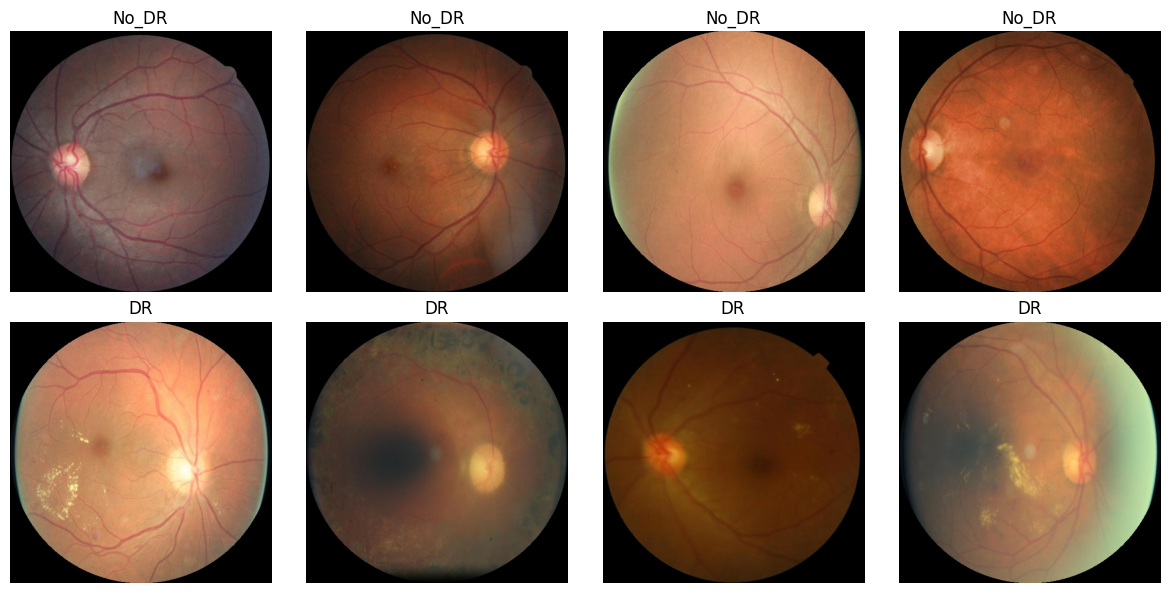

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

def show_sample_images(df, samples_per_class=4):
    classes = df['binary_level'].unique()
    plt.figure(figsize=(samples_per_class * 3, len(classes) * 3))
    i = 1
    for label in classes:
        sample_df = df[df['binary_level'] == label].sample(samples_per_class, random_state=42)
        for _, row in sample_df.iterrows():
            img = Image.open(row['path'])
            plt.subplot(len(classes), samples_per_class, i)
            plt.imshow(img, cmap='gray')
            plt.title("DR" if label else "No_DR")
            plt.axis('off')
            i += 1
    plt.tight_layout()
    plt.show()

show_sample_images(df)


Image Size Distribution

Measuring dimensions: 100%|██████████| 18632/18632 [00:01<00:00, 12424.00it/s]


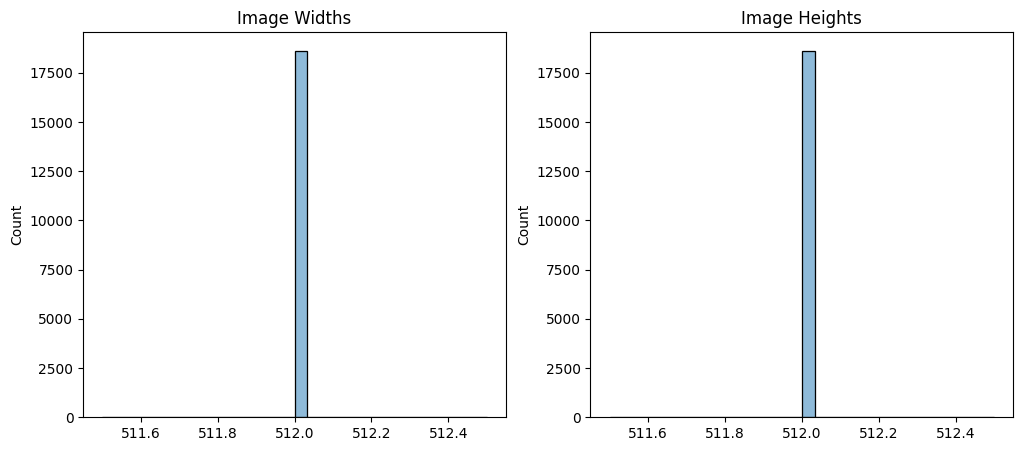

In [ ]:
from tqdm import tqdm

sizes = []

for path in tqdm(df['path'], desc="Measuring dimensions"):
    try:
        img = Image.open(path)
        sizes.append(img.size)
    except:
        continue

widths, heights = zip(*sizes)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(widths, bins=30, kde=True)
plt.title("Image Widths")
plt.subplot(1,2,2)
sns.histplot(heights, bins=30, kde=True)
plt.title("Image Heights")
plt.show()


Aspect Ratio Distribution

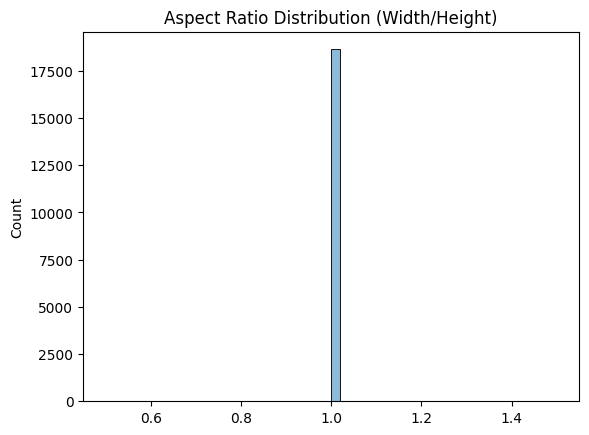

In [ ]:
aspect_ratios = [w/h for (w, h) in sizes]
sns.histplot(aspect_ratios, bins=50, kde=True)
plt.title("Aspect Ratio Distribution (Width/Height)")
plt.show()


Brightness and Contrast

Brightness & Contrast: 100%|██████████| 18632/18632 [00:38<00:00, 481.20it/s]


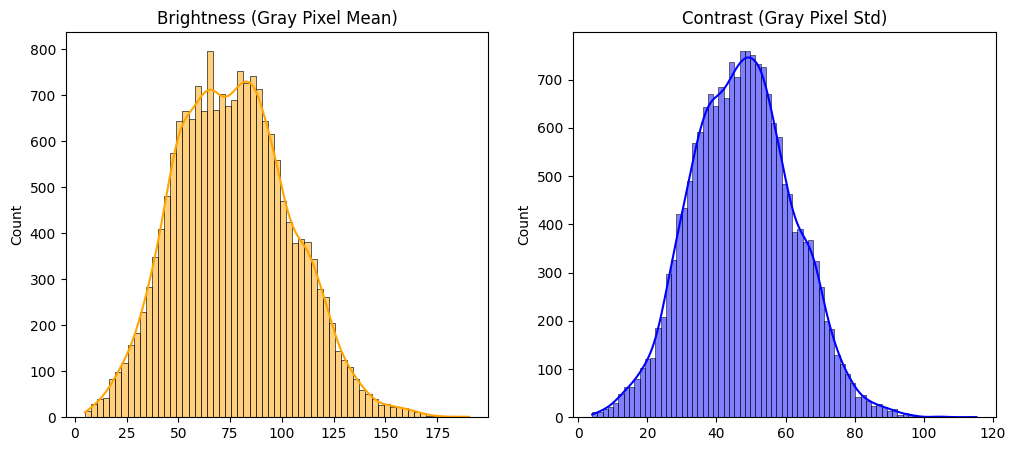

In [ ]:
import cv2
brightness_vals = []
contrast_vals = []

for path in tqdm(df['path'], desc="Brightness & Contrast"):
    try:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        brightness_vals.append(np.mean(img))
        contrast_vals.append(np.std(img))
    except:
        continue

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(brightness_vals, kde=True, color='orange')
plt.title("Brightness (Gray Pixel Mean)")
plt.subplot(1, 2, 2)
sns.histplot(contrast_vals, kde=True, color='blue')
plt.title("Contrast (Gray Pixel Std)")
plt.show()


Visual t-SNE on Image Embeddings

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Resize all to same size and flatten
image_vectors = []
labels = []

for _, row in tqdm(df.iterrows(), total=len(df), desc="Preparing vectors"):
    try:
        img = cv2.imread(row['path'], cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64, 64))  # Make small for speed
        image_vectors.append(img.flatten())
        labels.append(row['binary_level'])
    except:
        continue

X = np.array(image_vectors)
y = np.array(labels)

# Normalize
X_scaled = StandardScaler().fit_transform(X)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette=['green', 'red'], alpha=0.7)
plt.title("t-SNE of Fundus Images (0 = No_DR, 1 = DR)")
plt.show()


Preparing vectors: 100%|██████████| 18632/18632 [00:34<00:00, 542.57it/s]


KeyboardInterrupt: 

t-SNE/PCA with CNN Features (More Accurate)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  0%|          | 1/500 [00:01<15:41,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


  0%|          | 2/500 [00:02<07:33,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


  1%|          | 3/500 [00:02<04:57,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|          | 4/500 [00:02<03:42,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  1%|          | 5/500 [00:02<03:20,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  1%|          | 6/500 [00:03<03:07,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  1%|▏         | 7/500 [00:03<03:07,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


  2%|▏         | 8/500 [00:04<03:36,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  2%|▏         | 9/500 [00:04<03:06,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  2%|▏         | 10/500 [00:04<02:46,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  2%|▏         | 11/500 [00:04<02:18,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


  2%|▏         | 12/500 [00:05<02:08,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


  3%|▎         | 13/500 [00:05<01:50,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


  3%|▎         | 14/500 [00:05<01:49,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


  3%|▎         | 15/500 [00:05<01:48,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|▎         | 16/500 [00:05<01:54,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|▎         | 17/500 [00:06<01:55,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  4%|▎         | 18/500 [00:06<01:56,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|▍         | 19/500 [00:06<01:54,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  4%|▍         | 20/500 [00:06<01:54,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  4%|▍         | 21/500 [00:07<01:56,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|▍         | 22/500 [00:07<01:58,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  5%|▍         | 23/500 [00:07<02:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  5%|▍         | 24/500 [00:08<02:46,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


  5%|▌         | 25/500 [00:08<02:32,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  5%|▌         | 26/500 [00:08<02:26,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  5%|▌         | 27/500 [00:09<02:20,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  6%|▌         | 28/500 [00:09<02:14,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


  6%|▌         | 29/500 [00:09<01:55,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


  6%|▌         | 30/500 [00:09<01:51,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  6%|▌         | 31/500 [00:09<01:49,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  6%|▋         | 32/500 [00:10<01:47,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  7%|▋         | 33/500 [00:10<01:45,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  7%|▋         | 34/500 [00:10<01:43,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


  7%|▋         | 35/500 [00:10<01:42,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  7%|▋         | 36/500 [00:10<01:32,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


  7%|▋         | 37/500 [00:11<01:35,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


  8%|▊         | 38/500 [00:11<01:36,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


  8%|▊         | 39/500 [00:11<01:37,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


  8%|▊         | 40/500 [00:11<01:39,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  8%|▊         | 41/500 [00:11<01:39,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


  8%|▊         | 42/500 [00:12<01:40,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  9%|▊         | 43/500 [00:12<01:39,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  9%|▉         | 44/500 [00:12<01:39,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  9%|▉         | 45/500 [00:12<01:29,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  9%|▉         | 46/500 [00:13<01:32,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


  9%|▉         | 47/500 [00:13<01:35,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 10%|▉         | 48/500 [00:13<01:37,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 10%|▉         | 49/500 [00:13<01:38,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 10%|█         | 50/500 [00:13<01:40,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 10%|█         | 51/500 [00:14<01:39,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 10%|█         | 52/500 [00:14<01:30,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 11%|█         | 53/500 [00:14<01:32,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 11%|█         | 54/500 [00:14<01:33,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 11%|█         | 55/500 [00:14<01:37,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 11%|█         | 56/500 [00:15<01:28,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 11%|█▏        | 57/500 [00:15<01:30,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 12%|█▏        | 58/500 [00:15<01:22,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 12%|█▏        | 59/500 [00:15<01:21,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 12%|█▏        | 60/500 [00:15<01:19,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 12%|█▏        | 61/500 [00:16<01:24,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 12%|█▏        | 62/500 [00:16<01:19,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 13%|█▎        | 63/500 [00:16<01:24,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 13%|█▎        | 64/500 [00:16<01:17,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 13%|█▎        | 65/500 [00:16<01:22,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 13%|█▎        | 66/500 [00:17<01:27,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 13%|█▎        | 67/500 [00:17<01:19,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 14%|█▎        | 68/500 [00:17<01:23,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 14%|█▍        | 69/500 [00:17<01:17,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 14%|█▍        | 70/500 [00:17<01:12,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 14%|█▍        | 71/500 [00:17<01:18,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 14%|█▍        | 72/500 [00:18<01:23,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 15%|█▍        | 73/500 [00:18<01:26,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 15%|█▍        | 74/500 [00:18<01:19,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 15%|█▌        | 75/500 [00:18<01:23,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 15%|█▌        | 76/500 [00:18<01:26,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 15%|█▌        | 77/500 [00:19<01:27,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 16%|█▌        | 78/500 [00:19<01:28,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 16%|█▌        | 79/500 [00:19<01:34,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 16%|█▌        | 80/500 [00:19<01:37,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 16%|█▌        | 81/500 [00:20<01:42,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 16%|█▋        | 82/500 [00:20<01:36,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 17%|█▋        | 83/500 [00:20<01:37,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 17%|█▋        | 84/500 [00:20<01:43,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 17%|█▋        | 85/500 [00:21<01:43,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 17%|█▋        | 86/500 [00:21<01:43,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 17%|█▋        | 87/500 [00:21<01:44,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 18%|█▊        | 88/500 [00:21<01:37,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 18%|█▊        | 89/500 [00:22<01:39,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 18%|█▊        | 90/500 [00:22<01:39,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 18%|█▊        | 91/500 [00:22<01:39,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 18%|█▊        | 92/500 [00:22<01:40,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 19%|█▊        | 93/500 [00:23<01:41,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 19%|█▉        | 94/500 [00:23<01:30,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 19%|█▉        | 95/500 [00:23<01:29,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 19%|█▉        | 96/500 [00:23<01:30,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 19%|█▉        | 97/500 [00:23<01:29,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 20%|█▉        | 98/500 [00:24<01:29,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 20%|█▉        | 99/500 [00:24<01:30,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 20%|██        | 100/500 [00:24<01:30,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 20%|██        | 101/500 [00:24<01:20,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 20%|██        | 102/500 [00:24<01:12,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 21%|██        | 103/500 [00:25<01:07,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 21%|██        | 104/500 [00:25<01:12,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 21%|██        | 105/500 [00:25<01:16,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 21%|██        | 106/500 [00:25<01:19,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 21%|██▏       | 107/500 [00:25<01:11,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 22%|██▏       | 108/500 [00:26<01:16,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 22%|██▏       | 109/500 [00:26<01:19,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 22%|██▏       | 110/500 [00:26<01:12,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 22%|██▏       | 111/500 [00:26<01:16,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 22%|██▏       | 112/500 [00:26<01:19,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 23%|██▎       | 113/500 [00:26<01:11,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 23%|██▎       | 114/500 [00:27<01:15,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 23%|██▎       | 115/500 [00:27<01:18,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 23%|██▎       | 116/500 [00:27<01:20,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 23%|██▎       | 117/500 [00:27<01:12,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 24%|██▎       | 118/500 [00:27<01:15,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 24%|██▍       | 119/500 [00:28<01:09,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 24%|██▍       | 120/500 [00:28<01:15,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 24%|██▍       | 121/500 [00:28<01:18,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 24%|██▍       | 122/500 [00:28<01:19,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 25%|██▍       | 123/500 [00:29<01:22,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 25%|██▍       | 124/500 [00:29<01:23,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 25%|██▌       | 125/500 [00:29<01:23,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 25%|██▌       | 126/500 [00:29<01:22,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 25%|██▌       | 127/500 [00:29<01:22,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 26%|██▌       | 128/500 [00:30<01:22,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 26%|██▌       | 129/500 [00:30<01:22,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 26%|██▌       | 130/500 [00:30<01:12,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 26%|██▌       | 131/500 [00:30<01:14,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 26%|██▋       | 132/500 [00:30<01:08,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 27%|██▋       | 133/500 [00:31<01:04,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 27%|██▋       | 134/500 [00:31<01:09,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 27%|██▋       | 135/500 [00:31<01:12,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 27%|██▋       | 136/500 [00:31<01:15,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 27%|██▋       | 137/500 [00:31<01:16,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 28%|██▊       | 138/500 [00:32<01:08,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 28%|██▊       | 139/500 [00:32<01:02,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 28%|██▊       | 140/500 [00:32<01:07,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 28%|██▊       | 141/500 [00:32<01:10,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 28%|██▊       | 142/500 [00:32<01:12,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 29%|██▊       | 143/500 [00:33<01:07,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 29%|██▉       | 144/500 [00:33<01:13,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 29%|██▉       | 145/500 [00:33<01:18,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 29%|██▉       | 146/500 [00:33<01:17,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 29%|██▉       | 147/500 [00:33<01:21,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 30%|██▉       | 148/500 [00:34<01:18,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 30%|██▉       | 149/500 [00:34<01:21,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 30%|███       | 150/500 [00:34<01:25,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 30%|███       | 151/500 [00:34<01:26,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 30%|███       | 152/500 [00:35<01:25,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 31%|███       | 153/500 [00:35<01:25,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 31%|███       | 154/500 [00:35<01:27,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 31%|███       | 155/500 [00:35<01:26,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 31%|███       | 156/500 [00:36<01:28,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 31%|███▏      | 157/500 [00:36<01:28,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 32%|███▏      | 158/500 [00:36<01:28,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 32%|███▏      | 159/500 [00:36<01:24,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 32%|███▏      | 160/500 [00:37<01:13,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 32%|███▏      | 161/500 [00:37<01:13,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 32%|███▏      | 162/500 [00:37<01:05,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 33%|███▎      | 163/500 [00:37<01:00,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 33%|███▎      | 164/500 [00:37<00:58,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 33%|███▎      | 165/500 [00:38<01:02,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 33%|███▎      | 166/500 [00:38<00:57,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 33%|███▎      | 167/500 [00:38<01:01,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 34%|███▎      | 168/500 [00:38<00:58,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 34%|███▍      | 169/500 [00:38<01:02,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 34%|███▍      | 170/500 [00:38<01:05,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 34%|███▍      | 171/500 [00:39<01:00,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 34%|███▍      | 172/500 [00:39<01:04,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 35%|███▍      | 173/500 [00:39<01:06,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 35%|███▍      | 174/500 [00:39<01:07,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 35%|███▌      | 175/500 [00:40<01:08,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 35%|███▌      | 176/500 [00:40<01:09,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 35%|███▌      | 177/500 [00:40<01:10,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 36%|███▌      | 178/500 [00:40<01:10,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 36%|███▌      | 179/500 [00:40<01:10,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 36%|███▌      | 180/500 [00:41<01:04,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 36%|███▌      | 181/500 [00:41<00:59,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 36%|███▋      | 182/500 [00:41<01:02,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 37%|███▋      | 183/500 [00:41<01:04,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 37%|███▋      | 184/500 [00:41<01:06,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 37%|███▋      | 185/500 [00:42<01:07,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 37%|███▋      | 186/500 [00:42<01:00,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 37%|███▋      | 187/500 [00:42<01:03,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 38%|███▊      | 188/500 [00:42<01:04,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 38%|███▊      | 189/500 [00:42<01:05,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 38%|███▊      | 190/500 [00:43<01:05,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 38%|███▊      | 191/500 [00:43<01:06,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 38%|███▊      | 192/500 [00:43<01:07,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 39%|███▊      | 193/500 [00:43<01:09,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 39%|███▉      | 194/500 [00:44<01:09,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 39%|███▉      | 195/500 [00:44<01:02,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 39%|███▉      | 196/500 [00:44<01:03,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 39%|███▉      | 197/500 [00:44<01:04,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 40%|███▉      | 198/500 [00:44<01:05,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 40%|███▉      | 199/500 [00:45<01:05,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 40%|████      | 200/500 [00:45<01:05,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 40%|████      | 201/500 [00:45<00:58,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 40%|████      | 202/500 [00:45<00:54,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 41%|████      | 203/500 [00:45<01:00,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 41%|████      | 204/500 [00:46<00:57,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 41%|████      | 205/500 [00:46<01:00,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 41%|████      | 206/500 [00:46<01:02,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 41%|████▏     | 207/500 [00:46<01:03,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 42%|████▏     | 208/500 [00:46<01:04,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 42%|████▏     | 209/500 [00:47<01:06,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 42%|████▏     | 210/500 [00:47<01:08,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 42%|████▏     | 211/500 [00:47<01:09,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 42%|████▏     | 212/500 [00:47<01:09,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 43%|████▎     | 213/500 [00:48<01:07,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 43%|████▎     | 214/500 [00:48<01:10,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 43%|████▎     | 215/500 [00:48<01:11,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 43%|████▎     | 216/500 [00:48<01:12,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 43%|████▎     | 217/500 [00:49<01:11,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 44%|████▎     | 218/500 [00:49<01:11,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 44%|████▍     | 219/500 [00:49<01:07,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 44%|████▍     | 220/500 [00:49<01:09,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 44%|████▍     | 221/500 [00:50<01:09,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 44%|████▍     | 222/500 [00:50<01:10,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 45%|████▍     | 223/500 [00:50<01:11,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 45%|████▍     | 224/500 [00:50<01:01,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 45%|████▌     | 225/500 [00:50<00:54,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 45%|████▌     | 226/500 [00:51<00:50,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 45%|████▌     | 227/500 [00:51<00:52,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 46%|████▌     | 228/500 [00:51<00:49,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 46%|████▌     | 229/500 [00:51<00:46,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 46%|████▌     | 230/500 [00:51<00:45,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 46%|████▌     | 231/500 [00:52<00:49,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 46%|████▋     | 232/500 [00:52<00:46,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 47%|████▋     | 233/500 [00:52<00:50,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 47%|████▋     | 234/500 [00:52<00:52,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 47%|████▋     | 235/500 [00:52<00:54,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 47%|████▋     | 236/500 [00:53<00:55,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 47%|████▋     | 237/500 [00:53<00:55,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 48%|████▊     | 238/500 [00:53<00:57,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 48%|████▊     | 239/500 [00:53<00:56,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 48%|████▊     | 240/500 [00:53<00:57,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 48%|████▊     | 241/500 [00:54<00:52,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 48%|████▊     | 242/500 [00:54<00:53,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 49%|████▊     | 243/500 [00:54<00:54,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 49%|████▉     | 244/500 [00:54<00:55,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 49%|████▉     | 245/500 [00:55<00:55,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 49%|████▉     | 246/500 [00:55<00:55,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 49%|████▉     | 247/500 [00:55<00:55,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 50%|████▉     | 248/500 [00:55<00:55,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 50%|████▉     | 249/500 [00:55<00:55,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 50%|█████     | 250/500 [00:56<00:54,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 50%|█████     | 251/500 [00:56<00:54,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 50%|█████     | 252/500 [00:56<00:56,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 51%|█████     | 253/500 [00:56<00:50,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 51%|█████     | 254/500 [00:56<00:47,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 51%|█████     | 255/500 [00:57<00:44,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 51%|█████     | 256/500 [00:57<00:42,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 51%|█████▏    | 257/500 [00:57<00:46,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 52%|█████▏    | 258/500 [00:57<00:48,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 52%|█████▏    | 259/500 [00:57<00:50,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 52%|█████▏    | 260/500 [00:58<00:50,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 52%|█████▏    | 261/500 [00:58<00:51,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 52%|█████▏    | 262/500 [00:58<00:52,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 53%|█████▎    | 263/500 [00:58<00:52,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 53%|█████▎    | 264/500 [00:59<00:52,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 53%|█████▎    | 265/500 [00:59<00:48,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 53%|█████▎    | 266/500 [00:59<00:49,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 53%|█████▎    | 267/500 [00:59<00:50,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 54%|█████▎    | 268/500 [00:59<00:46,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 54%|█████▍    | 269/500 [01:00<00:47,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 54%|█████▍    | 270/500 [01:00<00:48,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 54%|█████▍    | 271/500 [01:00<00:49,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 54%|█████▍    | 272/500 [01:00<00:46,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 55%|█████▍    | 273/500 [01:00<00:50,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 55%|█████▍    | 274/500 [01:01<00:52,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 55%|█████▌    | 275/500 [01:01<00:53,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 55%|█████▌    | 276/500 [01:01<00:55,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████▌    | 277/500 [01:01<00:56,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 56%|█████▌    | 278/500 [01:02<00:57,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 56%|█████▌    | 279/500 [01:02<00:58,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 56%|█████▌    | 280/500 [01:02<00:58,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 56%|█████▌    | 281/500 [01:02<00:54,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 56%|█████▋    | 282/500 [01:03<00:55,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 57%|█████▋    | 283/500 [01:03<00:56,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 57%|█████▋    | 284/500 [01:03<00:54,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 57%|█████▋    | 285/500 [01:04<00:54,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 57%|█████▋    | 286/500 [01:04<00:52,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 57%|█████▋    | 287/500 [01:04<00:53,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 58%|█████▊    | 288/500 [01:04<00:53,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 58%|█████▊    | 289/500 [01:04<00:52,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 58%|█████▊    | 290/500 [01:05<00:50,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 58%|█████▊    | 291/500 [01:05<00:50,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 58%|█████▊    | 292/500 [01:05<00:49,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 59%|█████▊    | 293/500 [01:05<00:48,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 59%|█████▉    | 294/500 [01:06<00:42,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 59%|█████▉    | 295/500 [01:06<00:43,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 59%|█████▉    | 296/500 [01:06<00:39,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 59%|█████▉    | 297/500 [01:06<00:41,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 60%|█████▉    | 298/500 [01:06<00:42,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 60%|█████▉    | 299/500 [01:07<00:42,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 60%|██████    | 300/500 [01:07<00:43,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 60%|██████    | 301/500 [01:07<00:43,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 60%|██████    | 302/500 [01:07<00:39,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 61%|██████    | 303/500 [01:07<00:41,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 61%|██████    | 304/500 [01:08<00:37,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 61%|██████    | 305/500 [01:08<00:35,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 61%|██████    | 306/500 [01:08<00:33,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 61%|██████▏   | 307/500 [01:08<00:36,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 62%|██████▏   | 308/500 [01:08<00:34,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 62%|██████▏   | 309/500 [01:08<00:36,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 62%|██████▏   | 310/500 [01:09<00:38,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 62%|██████▏   | 311/500 [01:09<00:39,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 62%|██████▏   | 312/500 [01:09<00:40,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 63%|██████▎   | 313/500 [01:09<00:41,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 63%|██████▎   | 314/500 [01:10<00:41,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 63%|██████▎   | 315/500 [01:10<00:41,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 63%|██████▎   | 316/500 [01:10<00:41,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 63%|██████▎   | 317/500 [01:10<00:40,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 64%|██████▎   | 318/500 [01:11<00:40,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 64%|██████▍   | 319/500 [01:11<00:40,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 64%|██████▍   | 320/500 [01:11<00:36,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 64%|██████▍   | 321/500 [01:11<00:37,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 64%|██████▍   | 322/500 [01:11<00:37,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 65%|██████▍   | 323/500 [01:12<00:37,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 65%|██████▍   | 324/500 [01:12<00:34,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 65%|██████▌   | 325/500 [01:12<00:33,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 65%|██████▌   | 326/500 [01:12<00:35,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 65%|██████▌   | 327/500 [01:12<00:36,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 66%|██████▌   | 328/500 [01:13<00:36,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 66%|██████▌   | 329/500 [01:13<00:33,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 66%|██████▌   | 330/500 [01:13<00:32,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 66%|██████▌   | 331/500 [01:13<00:30,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 66%|██████▋   | 332/500 [01:13<00:32,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 67%|██████▋   | 333/500 [01:14<00:33,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 67%|██████▋   | 334/500 [01:14<00:31,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 67%|██████▋   | 335/500 [01:14<00:32,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 67%|██████▋   | 336/500 [01:14<00:34,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 67%|██████▋   | 337/500 [01:14<00:37,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 68%|██████▊   | 338/500 [01:15<00:39,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 68%|██████▊   | 339/500 [01:15<00:40,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|██████▊   | 340/500 [01:15<00:40,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 68%|██████▊   | 341/500 [01:15<00:41,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 68%|██████▊   | 342/500 [01:16<00:41,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 69%|██████▊   | 343/500 [01:16<00:42,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 69%|██████▉   | 344/500 [01:16<00:41,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 69%|██████▉   | 345/500 [01:17<00:40,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 69%|██████▉   | 346/500 [01:17<00:38,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 69%|██████▉   | 347/500 [01:17<00:38,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 70%|██████▉   | 348/500 [01:17<00:37,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 70%|██████▉   | 349/500 [01:18<00:39,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 70%|███████   | 350/500 [01:18<00:39,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 70%|███████   | 351/500 [01:18<00:40,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 70%|███████   | 352/500 [01:18<00:39,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 71%|███████   | 353/500 [01:19<00:36,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 71%|███████   | 354/500 [01:19<00:35,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 71%|███████   | 355/500 [01:19<00:31,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 71%|███████   | 356/500 [01:19<00:28,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 71%|███████▏  | 357/500 [01:19<00:26,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 72%|███████▏  | 358/500 [01:20<00:27,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 72%|███████▏  | 359/500 [01:20<00:28,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 72%|███████▏  | 360/500 [01:20<00:27,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 72%|███████▏  | 361/500 [01:20<00:29,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 72%|███████▏  | 362/500 [01:20<00:29,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 73%|███████▎  | 363/500 [01:21<00:27,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 73%|███████▎  | 364/500 [01:21<00:25,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 73%|███████▎  | 365/500 [01:21<00:24,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 73%|███████▎  | 366/500 [01:21<00:23,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 73%|███████▎  | 367/500 [01:21<00:25,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 74%|███████▎  | 368/500 [01:21<00:26,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 74%|███████▍  | 369/500 [01:22<00:27,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 74%|███████▍  | 370/500 [01:22<00:25,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 74%|███████▍  | 371/500 [01:22<00:25,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 74%|███████▍  | 372/500 [01:22<00:26,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 75%|███████▍  | 373/500 [01:23<00:27,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 75%|███████▍  | 374/500 [01:23<00:27,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 75%|███████▌  | 375/500 [01:23<00:27,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 75%|███████▌  | 376/500 [01:23<00:28,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 75%|███████▌  | 377/500 [01:23<00:25,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 76%|███████▌  | 378/500 [01:24<00:23,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 76%|███████▌  | 379/500 [01:24<00:24,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 76%|███████▌  | 380/500 [01:24<00:25,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 76%|███████▌  | 381/500 [01:24<00:25,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 76%|███████▋  | 382/500 [01:24<00:25,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 77%|███████▋  | 383/500 [01:25<00:23,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 77%|███████▋  | 384/500 [01:25<00:23,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 77%|███████▋  | 385/500 [01:25<00:22,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 77%|███████▋  | 386/500 [01:25<00:23,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 77%|███████▋  | 387/500 [01:25<00:22,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 78%|███████▊  | 388/500 [01:26<00:20,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 78%|███████▊  | 389/500 [01:26<00:21,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 78%|███████▊  | 390/500 [01:26<00:22,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 78%|███████▊  | 391/500 [01:26<00:21,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 78%|███████▊  | 392/500 [01:26<00:22,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 79%|███████▊  | 393/500 [01:27<00:22,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 79%|███████▉  | 394/500 [01:27<00:22,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 79%|███████▉  | 395/500 [01:27<00:20,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 79%|███████▉  | 396/500 [01:27<00:19,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 79%|███████▉  | 397/500 [01:27<00:18,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 80%|███████▉  | 398/500 [01:28<00:19,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 80%|███████▉  | 399/500 [01:28<00:21,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 80%|████████  | 400/500 [01:29<00:48,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 80%|████████  | 401/500 [01:30<00:52,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 80%|████████  | 402/500 [01:30<00:44,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 81%|████████  | 403/500 [01:30<00:38,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 81%|████████  | 404/500 [01:30<00:34,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 81%|████████  | 405/500 [01:31<00:30,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 81%|████████  | 406/500 [01:31<00:28,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 81%|████████▏ | 407/500 [01:31<00:26,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 82%|████████▏ | 408/500 [01:31<00:25,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 82%|████████▏ | 409/500 [01:32<00:25,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 82%|████████▏ | 410/500 [01:32<00:23,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|████████▏ | 411/500 [01:32<00:23,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 82%|████████▏ | 412/500 [01:32<00:22,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 83%|████████▎ | 413/500 [01:33<00:21,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 83%|████████▎ | 414/500 [01:33<00:20,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 83%|████████▎ | 415/500 [01:33<00:18,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 83%|████████▎ | 416/500 [01:33<00:18,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 83%|████████▎ | 417/500 [01:33<00:16,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 84%|████████▎ | 418/500 [01:34<00:16,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 84%|████████▍ | 419/500 [01:34<00:15,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 84%|████████▍ | 420/500 [01:34<00:14,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 84%|████████▍ | 421/500 [01:34<00:15,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 84%|████████▍ | 422/500 [01:34<00:15,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 85%|████████▍ | 423/500 [01:35<00:16,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 85%|████████▍ | 424/500 [01:35<00:16,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 85%|████████▌ | 425/500 [01:35<00:16,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 85%|████████▌ | 426/500 [01:35<00:16,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 85%|████████▌ | 427/500 [01:35<00:14,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 86%|████████▌ | 428/500 [01:36<00:13,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 86%|████████▌ | 429/500 [01:36<00:14,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 86%|████████▌ | 430/500 [01:36<00:13,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|████████▌ | 431/500 [01:36<00:12,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 86%|████████▋ | 432/500 [01:36<00:13,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 87%|████████▋ | 433/500 [01:37<00:12,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 87%|████████▋ | 434/500 [01:37<00:11,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 87%|████████▋ | 435/500 [01:37<00:12,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 87%|████████▋ | 436/500 [01:37<00:11,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████▋ | 437/500 [01:37<00:12,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 88%|████████▊ | 438/500 [01:37<00:11,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 88%|████████▊ | 439/500 [01:38<00:11,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 88%|████████▊ | 440/500 [01:38<00:11,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 88%|████████▊ | 441/500 [01:38<00:10,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 88%|████████▊ | 442/500 [01:38<00:09,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 89%|████████▊ | 443/500 [01:38<00:09,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 89%|████████▉ | 444/500 [01:38<00:09,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 89%|████████▉ | 445/500 [01:39<00:09,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 89%|████████▉ | 446/500 [01:39<00:10,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 89%|████████▉ | 447/500 [01:39<00:09,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 90%|████████▉ | 448/500 [01:39<00:10,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|████████▉ | 449/500 [01:39<00:09,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 90%|█████████ | 450/500 [01:40<00:08,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 90%|█████████ | 451/500 [01:40<00:09,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 90%|█████████ | 452/500 [01:40<00:08,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|█████████ | 453/500 [01:40<00:09,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|█████████ | 454/500 [01:40<00:09,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 91%|█████████ | 455/500 [01:41<00:09,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 91%|█████████ | 456/500 [01:41<00:09,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 91%|█████████▏| 457/500 [01:41<00:09,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 92%|█████████▏| 458/500 [01:41<00:09,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 92%|█████████▏| 459/500 [01:42<00:09,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 92%|█████████▏| 460/500 [01:42<00:09,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 92%|█████████▏| 461/500 [01:42<00:08,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 92%|█████████▏| 462/500 [01:42<00:08,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|█████████▎| 463/500 [01:42<00:07,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 93%|█████████▎| 464/500 [01:43<00:07,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 93%|█████████▎| 465/500 [01:43<00:07,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 93%|█████████▎| 466/500 [01:43<00:08,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 93%|█████████▎| 467/500 [01:43<00:07,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 94%|█████████▎| 468/500 [01:44<00:08,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 94%|█████████▍| 469/500 [01:44<00:07,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 94%|█████████▍| 470/500 [01:44<00:07,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 94%|█████████▍| 471/500 [01:44<00:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 94%|█████████▍| 472/500 [01:45<00:07,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 95%|█████████▍| 473/500 [01:45<00:06,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 95%|█████████▍| 474/500 [01:45<00:06,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 95%|█████████▌| 475/500 [01:45<00:06,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 95%|█████████▌| 476/500 [01:46<00:06,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 95%|█████████▌| 477/500 [01:46<00:06,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 96%|█████████▌| 478/500 [01:46<00:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 96%|█████████▌| 479/500 [01:46<00:05,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 96%|█████████▌| 480/500 [01:47<00:04,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 96%|█████████▌| 481/500 [01:47<00:04,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 96%|█████████▋| 482/500 [01:47<00:04,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 97%|█████████▋| 483/500 [01:47<00:03,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 97%|█████████▋| 484/500 [01:48<00:03,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 97%|█████████▋| 485/500 [01:48<00:03,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 97%|█████████▋| 486/500 [01:48<00:02,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 97%|█████████▋| 487/500 [01:48<00:02,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 98%|█████████▊| 488/500 [01:48<00:02,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|█████████▊| 489/500 [01:49<00:02,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 98%|█████████▊| 490/500 [01:49<00:02,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 98%|█████████▊| 491/500 [01:49<00:01,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 98%|█████████▊| 492/500 [01:49<00:01,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 99%|█████████▊| 493/500 [01:50<00:01,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 99%|█████████▉| 494/500 [01:50<00:01,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 99%|█████████▉| 495/500 [01:50<00:01,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 99%|█████████▉| 496/500 [01:51<00:01,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 99%|█████████▉| 497/500 [01:51<00:00,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


100%|█████████▉| 498/500 [01:51<00:00,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


100%|█████████▉| 499/500 [01:51<00:00,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


100%|██████████| 500/500 [01:52<00:00,  4.46it/s]


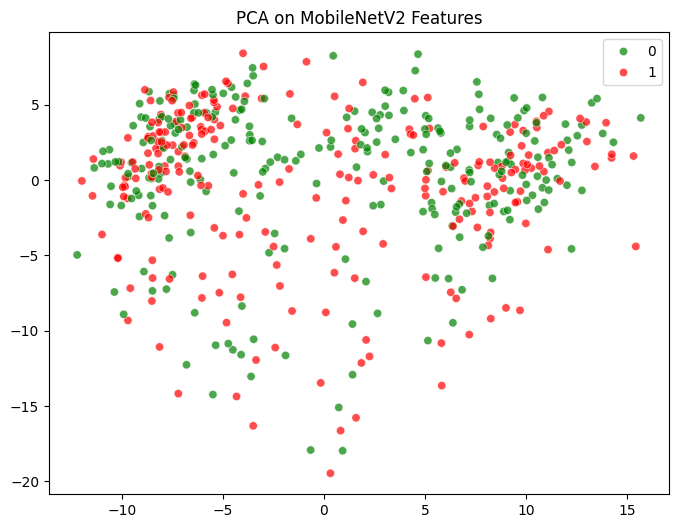

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.decomposition import PCA

model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(224,224,3))

features = []
labels = []

for _, row in tqdm(df.sample(500).iterrows(), total=500):
    try:
        img = image.load_img(row['path'], target_size=(224, 224))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        x = np.expand_dims(x, axis=0)
        feat = model.predict(x)
        features.append(feat.flatten())
        labels.append(row['binary_level'])
    except:
        continue

# PCA for 2D visualization
X_pca = PCA(n_components=2).fit_transform(features)

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette=['green','red'], alpha=0.7)
plt.title("PCA on MobileNetV2 Features")
plt.show()


Sharpness (Edge Gradient)

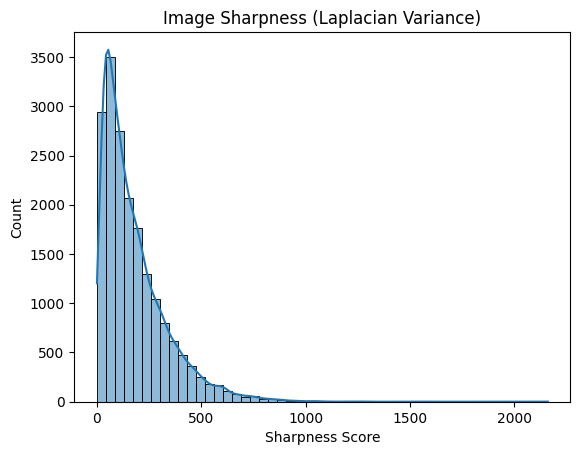

In [ ]:
sharpness_scores = []

for path in df['path']:
    try:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
        sharpness_scores.append(laplacian_var)
    except:
        continue

sns.histplot(sharpness_scores, bins=50, kde=True)
plt.title("Image Sharpness (Laplacian Variance)")
plt.xlabel("Sharpness Score")
plt.show()


Average or Variance Heatmaps

⚠️ Couldn't read image: /content/drive/MyDrive/EECE 490 Project/Cleaned_images/32253_right.jpeg


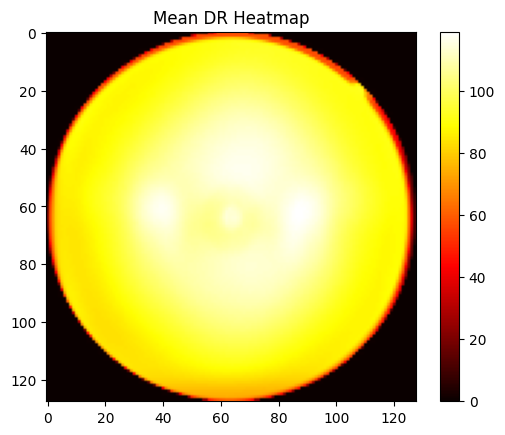

In [ ]:
import numpy as np
IMG_HEIGHT, IMG_WIDTH = 128, 128

mean_img = np.zeros((IMG_HEIGHT, IMG_WIDTH))
valid_count = 0

for path in df[df['binary_level'] == 1]['path']:
    img = cv2.imread(path, 0)
    if img is None:
        print(f"⚠️ Couldn't read image: {path}")
        continue
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    mean_img += img
    valid_count += 1

if valid_count > 0:
    mean_img /= valid_count
    plt.imshow(mean_img, cmap='hot')
    plt.title("Mean DR Heatmap")
    plt.colorbar()
    plt.show()
else:
    print("❌ No valid DR images were found.")


Edge Detection Visualization

In [ ]:
import cv2
import matplotlib.pyplot as plt
import random

# Pick a few DR images for demonstration
sample_paths = df[df['binary_level'] == 1]['path'].sample(5, random_state=42).tolist()

plt.figure(figsize=(15, 10))

for i, path in enumerate(sample_paths):
    # Read grayscale image
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))  # Resize for consistency

    # Sobel Edge Detection
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    sobel_combined = cv2.magnitude(sobelx, sobely)

    # Canny Edge Detection
    canny = cv2.Canny(img, 100, 200)

    # Plot original + Sobel + Canny
    plt.subplot(len(sample_paths), 3, i * 3 + 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(len(sample_paths), 3, i * 3 + 2)
    plt.imshow(sobel_combined, cmap='gray')
    plt.title("Sobel Edges")
    plt.axis('off')

    plt.subplot(len(sample_paths), 3, i * 3 + 3)
    plt.imshow(canny, cmap='gray')
    plt.title("Canny Edges")
    plt.axis('off')

plt.tight_layout()
plt.show()


NameError: name 'df' is not defined

SVD Analysis of Image Rank and Compression

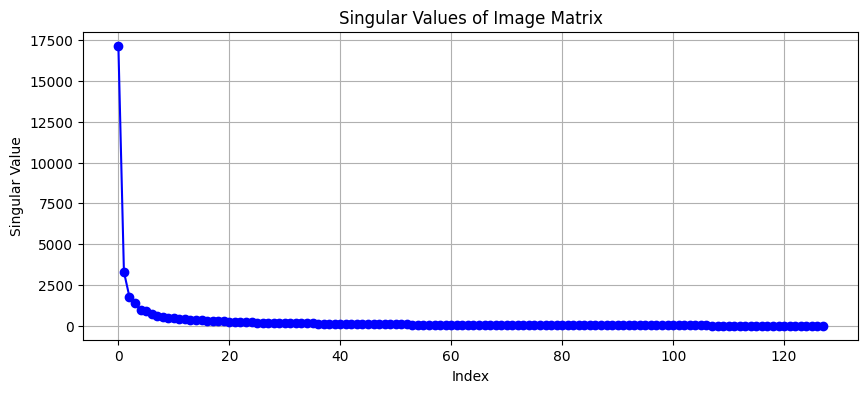

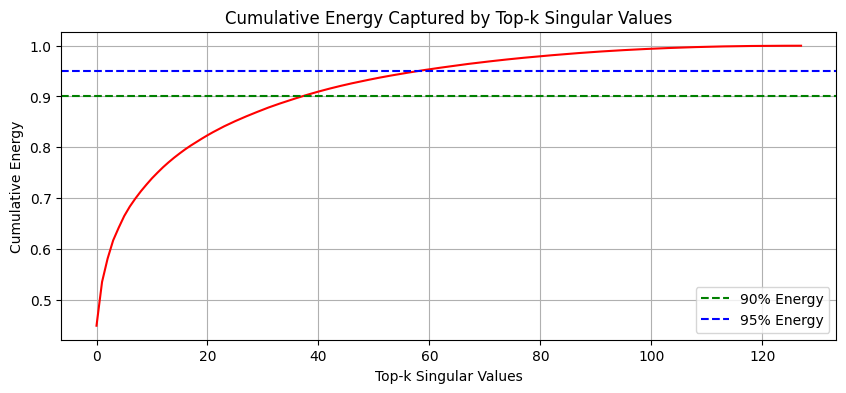

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

# Choose a sample image (DR class)
sample_path = df[df['binary_level'] == 1]['path'].sample(1, random_state=42).values[0]
img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (128, 128))  # Smaller size speeds up SVD

# Perform SVD
U, S, VT = np.linalg.svd(img, full_matrices=False)

# Plot singular values
plt.figure(figsize=(10, 4))
plt.plot(S, 'bo-')
plt.title("Singular Values of Image Matrix")
plt.xlabel("Index")
plt.ylabel("Singular Value")
plt.grid(True)
plt.show()

# Plot cumulative energy (info retained)
cum_energy = np.cumsum(S) / np.sum(S)
plt.figure(figsize=(10, 4))
plt.plot(cum_energy, 'r-')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% Energy')
plt.axhline(y=0.95, color='b', linestyle='--', label='95% Energy')
plt.title("Cumulative Energy Captured by Top-k Singular Values")
plt.xlabel("Top-k Singular Values")
plt.ylabel("Cumulative Energy")
plt.legend()
plt.grid(True)
plt.show()


Sharpness Outliers

In [ ]:
import numpy as np

# Assuming you already have a list of sharpness_scores
sharpness_scores = np.array(sharpness_scores)

# Calculate IQR
Q1 = np.percentile(sharpness_scores, 25)
Q3 = np.percentile(sharpness_scores, 75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Get indices of outliers
low_outliers = np.where(sharpness_scores < lower_bound)[0]
high_outliers = np.where(sharpness_scores > upper_bound)[0]

print(f"Low-sharpness outliers: {len(low_outliers)}")
print(f"High-sharpness outliers: {len(high_outliers)}")


NameError: name 'sharpness_scores' is not defined

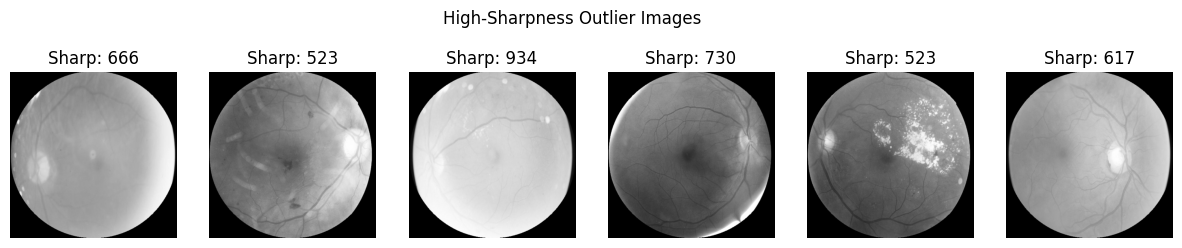

In [ ]:
outlier_paths = [df.iloc[i]['path'] for i in high_outliers[:6]]

plt.figure(figsize=(15, 3))
for i, path in enumerate(outlier_paths):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, 6, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Sharp: {sharpness_scores[high_outliers[i]]:.0f}')
    plt.axis('off')
plt.suptitle("High-Sharpness Outlier Images")
plt.show()


In [6]:
# ✅ FUNDUS IMAGE QUALITY FILTER — REMOVE LOW-QUALITY IMAGES + BAD DISK CENTERING

import os
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import shutil

# === SETTINGS ===
input_folder = "/content/drive/MyDrive/EECE 490 Project/Cleaned_images"
output_folder = "/content/drive/MyDrive/EECE 490 Project/High_Quality_Only"
os.makedirs(output_folder, exist_ok=True)

# === THRESHOLDS (tweak as needed) ===
min_sharpness = 50     # Lower = blurrier, typical good fundus images > 80
min_contrast = 20      # Too low = flat image
min_brightness = 20    # Avoid totally dark ones
max_brightness = 230   # Avoid burned bright ones
white_threshold_ratio = 0.01  # White artifacts like glare
min_circle_area_ratio = 0.4   # Retina circle must cover at least 40% of image

# === Helper Functions ===
def is_low_quality(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Sharpness (Laplacian variance)
    sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()

    # Contrast (std deviation)
    contrast = np.std(gray)

    # Brightness (mean)
    brightness = np.mean(gray)

    # White glare detection
    _, white_thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    white_ratio = np.sum(white_thresh == 255) / (gray.shape[0] * gray.shape[1])

    return (
        sharpness < min_sharpness or
        contrast < min_contrast or
        brightness < min_brightness or brightness > max_brightness or
        white_ratio > white_threshold_ratio
    )

def is_bad_centering(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return True
    largest_contour = max(contours, key=cv2.contourArea)
    (_, _), radius = cv2.minEnclosingCircle(largest_contour)
    circle_area = np.pi * radius * radius
    image_area = img.shape[0] * img.shape[1]
    return circle_area / image_area < min_circle_area_ratio

# === Run Filter ===
image_files = [f for f in os.listdir(input_folder) if f.endswith(".jpeg")]
removed = []
kept = 0

for fname in tqdm(image_files):
    img_path = os.path.join(input_folder, fname)
    try:
        img = cv2.imread(img_path)
        if is_low_quality(img) or is_bad_centering(img):
            removed.append(fname)
            continue
        shutil.copy(img_path, os.path.join(output_folder, fname))
        kept += 1
    except:
        removed.append(fname)

print(f"✅ Kept {kept} high-quality images with centered discs.")
print(f"❌ Removed {len(removed)} low-quality or off-center images out of {len(image_files)} total.")

# Optional: save list of removed images
with open("/content/removed_low_quality.txt", "w") as f:
    f.write("\n".join(removed))


100%|██████████| 18631/18631 [01:35<00:00, 195.00it/s]

✅ Kept 14504 high-quality images with centered discs.
❌ Removed 4127 low-quality or off-center images out of 18631 total.


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import shutil

# === SET YOUR PATHS ===
input_folder = "/content/drive/MyDrive/EECE 490 Project/Cleaned_images"
output_folder = "/content/drive/MyDrive/EECE 490 Project/High_Quality_Strict"
os.makedirs(output_folder, exist_ok=True)

# === STRONG FILTER THRESHOLDS ===
min_sharpness = 50
min_contrast = 20
min_brightness = 20
max_brightness = 200
max_white_ratio = 0.008
min_retina_area_ratio = 0.4
max_hue_std = 8
bottom_artifact_thresh = 220
bottom_percent = 0.15

# === QUALITY FILTERS ===
def is_low_quality(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()
    contrast = np.std(gray)
    brightness = np.mean(gray)
    _, white_thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    white_ratio = np.sum(white_thresh == 255) / (gray.shape[0] * gray.shape[1])
    return (
        sharpness < min_sharpness or
        contrast < min_contrast or
        brightness < min_brightness or brightness > max_brightness or
        white_ratio > max_white_ratio
    )

def is_poorly_centered(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return True
    largest = max(contours, key=cv2.contourArea)
    (_, _), radius = cv2.minEnclosingCircle(largest)
    retina_area = np.pi * radius * radius
    image_area = img.shape[0] * img.shape[1]
    return retina_area / image_area < min_retina_area_ratio

def has_visible_border(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    border = 10
    for edge in [gray[:border, :], gray[-border:, :], gray[:, :border], gray[:, -border:]]:
        if np.mean(edge) < 5:
            return True
    return False

def is_grayscale_in_rgb(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hue_std = np.std(hsv[:, :, 0])
    return hue_std < max_hue_std

def has_bright_bottom(img):
    h = img.shape[0]
    bottom = img[int(h * (1 - bottom_percent)):, :]
    return np.mean(bottom) > bottom_artifact_thresh

# === MAIN CLEANING LOOP ===
skipped = []
kept = 0
image_files = [f for f in os.listdir(input_folder) if f.endswith(".jpeg")]

for fname in tqdm(image_files):
    path = os.path.join(input_folder, fname)
    img = cv2.imread(path)

    if (
        img is None or
        is_low_quality(img) or
        is_poorly_centered(img) or
        has_visible_border(img) or
        is_grayscale_in_rgb(img) or
        has_bright_bottom(img)
    ):
        skipped.append(fname)
        continue

    shutil.copy(path, os.path.join(output_folder, fname))
    kept += 1

# === SUMMARY ===
print(f"\n📦 Dataset Summary:")
print(f"➡️ Total images processed: {len(image_files)}")
print(f"✅ Kept (high-quality, clean disc): {kept}")
print(f"❌ Removed (low-quality or imperfect disc): {len(skipped)}")

# === SAVE REMOVED LIST
with open("/content/removed_low_quality_strict.txt", "w") as f:
    f.write("\n".join(skipped))


100%|██████████| 18631/18631 [02:35<00:00, 120.15it/s]


📦 Dataset Summary:
➡️ Total images processed: 18631
✅ Kept (high-quality, clean disc): 3216
❌ Removed (low-quality or imperfect disc): 15415


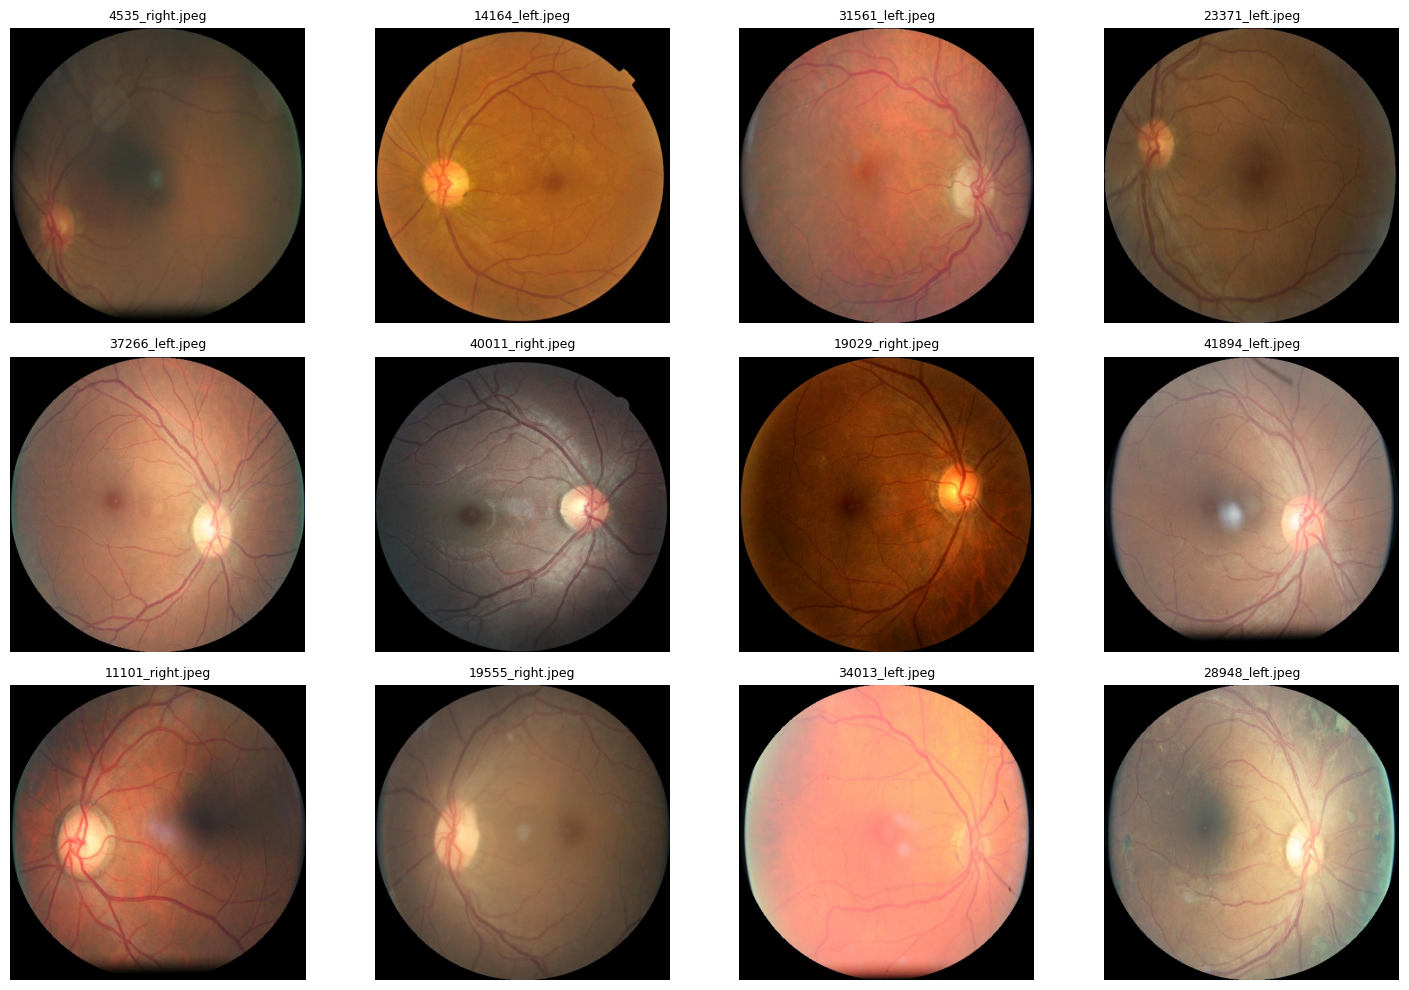

In [7]:
import os
import cv2
import matplotlib.pyplot as plt
import random

# Folder where your cropped & cleaned images are stored
image_folder = "/content/drive/MyDrive/EECE 490 Project/High_Quality_Only"

# Load all image filenames
image_files = [f for f in os.listdir(image_folder) if f.endswith(".jpeg")]

# Pick 12 random ones
sample_files = random.sample(image_files, 12)

# Plot grid
plt.figure(figsize=(15, 10))
for i, fname in enumerate(sample_files):
    img_path = os.path.join(image_folder, fname)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(fname, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [8]:
import os
import pandas as pd

# === Paths ===
cleaned_folder = "/content/drive/MyDrive/EECE 490 Project/High_Quality_Only"
csv_path = "/content/drive/MyDrive/EECE 490 Project/balanced_trainLabels.csv"  # Contains image names + binary_level

# === Load Labels ===
df = pd.read_csv(csv_path)

# Ensure filenames match format in folder (e.g., no extension in CSV)
df['image'] = df['image'].astype(str) + ".jpeg"

# Filter for files that still exist in the cleaned dataset
existing_images = set(os.listdir(cleaned_folder))
filtered_df = df[df['image'].isin(existing_images)]

# === Count 0 vs 1 ===
counts = filtered_df['binary_level'].value_counts().sort_index()

# === Print results ===
print("📊 Label Distribution in High_Quality_Strict:")
print(f"0 (No_DR): {counts.get(0, 0)}")
print(f"1 (DR):    {counts.get(1, 0)}")


📊 Label Distribution in High_Quality_Strict:
0 (No_DR): 7345
1 (DR):    7159


In [9]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# === Paths ===
cleaned_folder = "/content/drive/MyDrive/EECE 490 Project/High_Quality_Only"
csv_path = "/content/drive/MyDrive/EECE 490 Project/balanced_trainLabels.csv"

base_output = "/content/drive/MyDrive/EECE 490 Project/High_Quality_Split"
output_paths = {
    "NoDR_train": os.path.join(base_output, "NoDR", "train"),
    "NoDR_test": os.path.join(base_output, "NoDR", "test"),
    "DR_train": os.path.join(base_output, "DR", "train"),
    "DR_test": os.path.join(base_output, "DR", "test"),
}
for path in output_paths.values():
    os.makedirs(path, exist_ok=True)

# === Load and Match Labels ===
df = pd.read_csv(csv_path)
df['image'] = df['image'].astype(str) + ".jpeg"
existing_images = set(os.listdir(cleaned_folder))
filtered_df = df[df['image'].isin(existing_images)]

# === Split each class separately ===
no_dr_df = filtered_df[filtered_df['binary_level'] == 0]
dr_df = filtered_df[filtered_df['binary_level'] == 1]

no_dr_train, no_dr_test = train_test_split(no_dr_df, test_size=0.2, random_state=42)
dr_train, dr_test = train_test_split(dr_df, test_size=0.2, random_state=42)

# === Copy files to new folders ===
def copy_images(rows, target_folder):
    for _, row in rows.iterrows():
        src = os.path.join(cleaned_folder, row['image'])
        dst = os.path.join(target_folder, row['image'])
        shutil.copy(src, dst)

copy_images(no_dr_train, output_paths["NoDR_train"])
copy_images(no_dr_test, output_paths["NoDR_test"])
copy_images(dr_train, output_paths["DR_train"])
copy_images(dr_test, output_paths["DR_test"])

# === Summary ===
print("✅ Dataset split 80-20 into:")
print(f"🔹 DR     → {len(dr_train)} train / {len(dr_test)} test")
print(f"🔹 No_DR  → {len(no_dr_train)} train / {len(no_dr_test)} test")


✅ Dataset split 80-20 into:
🔹 DR     → 5727 train / 1432 test
🔹 No_DR  → 5876 train / 1469 test


In [10]:
import os
import cv2

input_folder = "/content/drive/MyDrive/EECE 490 Project/High_Quality_Split/DR/train"
output_folder = "/content/drive/MyDrive/EECE 490 Project/StyleGAN3_Ready/DR_train"
os.makedirs(output_folder, exist_ok=True)

for idx, fname in enumerate(sorted(os.listdir(input_folder))):
    if not fname.endswith(".jpeg"):
        continue
    img = cv2.imread(os.path.join(input_folder, fname))
    outname = f"image{idx:05d}.png"
    cv2.imwrite(os.path.join(output_folder, outname), img)

print("✅ Training images converted to .png and renamed.")


✅ Training images converted to .png and renamed.


In [73]:
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.7 torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.1/196.1 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

In [74]:
import torch
print("CUDA Available:", torch.cuda.is_available())


CUDA Available: True


In [11]:
!git clone https://github.com/NVlabs/stylegan3.git
%cd stylegan3


fatal: destination path 'stylegan3' already exists and is not an empty directory.
/content/stylegan3


In [76]:
# 🔧 Patch Adam betas to use tuple instead of list
!sed -i "s/betas=\[0,0.99\]/betas=(0.0, 0.99)/g" stylegan3/train.py


sed: can't read stylegan3/train.py: No such file or directory


In [12]:
!python dataset_tool.py \
  --source=/content/drive/MyDrive/EECE\ 490\ Project/StyleGAN3_Ready/DR_train \
  --dest=/content/DR_dataset.zip


100% 5727/5727 [02:10<00:00, 43.82it/s]


In [13]:
# Open the train.py file in write mode
file_path = "/content/stylegan3/train.py"

# Replace the betas lines
with open(file_path, "r") as file:
    lines = file.readlines()

with open(file_path, "w") as file:
    for line in lines:
        if "betas=[" in line:
            line = line.replace("betas=[0.0,0.99]", "betas=(float(0.0), float(0.99))")
        file.write(line)


In [14]:
# This will print the entire content of train.py to the notebook
with open('/content/stylegan3/train.py', 'r') as f:
    print(f.read())


# Copyright (c) 2021, NVIDIA CORPORATION & AFFILIATES.  All rights reserved.
#
# NVIDIA CORPORATION and its licensors retain all intellectual property
# and proprietary rights in and to this software, related documentation
# and any modifications thereto.  Any use, reproduction, disclosure or
# distribution of this software and related documentation without an express
# license agreement from NVIDIA CORPORATION is strictly prohibited.

"""Train a GAN using the techniques described in the paper
"Alias-Free Generative Adversarial Networks"."""

import os
import click
import re
import json
import tempfile
import torch

import dnnlib
from training import training_loop
from metrics import metric_main
from torch_utils import training_stats
from torch_utils import custom_ops

#----------------------------------------------------------------------------

def subprocess_fn(rank, c, temp_dir):
    dnnlib.util.Logger(file_name=os.path.join(c.run_dir, 'log.txt'), file_mode='a', should_flush=True)


In [15]:
!grep "betas=" /content/stylegan3/train.py


    c.G_opt_kwargs = dnnlib.EasyDict(class_name='torch.optim.Adam', betas=(float(0.0), float(0.99)), eps=1e-8)
    c.D_opt_kwargs = dnnlib.EasyDict(class_name='torch.optim.Adam', betas=(float(0.0), float(0.99)), eps=1e-8)


In [83]:
train_path = "/content/stylegan3/train.py"

# Read the content of the file
with open(train_path, "r") as f:
    code = f.read()

# Fix betas format if found
code = code.replace(
    "betas=[0,0.99]",  # in case the list version is there
    "betas=(float(0.0), float(0.99))"
).replace(
    "betas=[0, 0.99]",  # other spacing variant
    "betas=(float(0.0), float(0.99))"
)

# Save the modified code back
with open(train_path, "w") as f:
    f.write(code)

print("✅ Patched `train.py` successfully — betas are now tuples!")


✅ Patched `train.py` successfully — betas are now tuples!


In [ ]:
!python train.py \
  --outdir=/content/drive/MyDrive/EECE_490_Project/Training_Runs \
  --cfg=stylegan3-t \
  --data=/content/DR_dataset.zip \
  --gpus=1 \
  --batch=8 \
  --gamma=8.2 \
  --mirror=1 \
  --kimg=1000 \
  --snap=10 \
  --metrics=fid50k_full



Training options:
{
  "G_kwargs": {
    "class_name": "training.networks_stylegan3.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "channel_base": 32768,
    "channel_max": 512,
    "magnitude_ema_beta": 0.9997227795604651
  },
  "D_kwargs": {
    "class_name": "training.networks_stylegan2.Discriminator",
    "block_kwargs": {
      "freeze_layers": 0
    },
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base": 32768,
    "channel_max": 512
  },
  "G_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0.0,
      0.99
    ],
    "eps": 1e-08,
    "lr": 0.0025
  },
  "D_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0.0,
      0.99
    ],
    "eps": 1e-08,
    "lr": 0.002
  },
  "loss_kwargs": {
    "class_name": "training.loss.StyleGAN2Loss",
    "r1_gamma": 8.2
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "prefetch_

In [85]:
!sed -i 's/betas=(0.0, 0.99)/betas=(float(0.0), float(0.99))/g' /content/stylegan3/train.py


In [72]:
!grep -r "betas=" /content/stylegan3/


/content/stylegan3/train.py:    c.G_opt_kwargs = dnnlib.EasyDict(class_name='torch.optim.Adam', betas=(0.0, 0.99), eps=1e-8)
/content/stylegan3/train.py:    c.D_opt_kwargs = dnnlib.EasyDict(class_name='torch.optim.Adam', betas=(0.0, 0.99), eps=1e-8)


In [ ]:
%cd /content/drive/MyDrive/EECE_490_Project/Training_Runs/


/content/drive/MyDrive/EECE_490_Project/Training_Runs


In [ ]:
run_path = os.path.join(run_base, '00000-stylegan3-t-DR_dataset-gpus1-batch8-gamma8.2')  # update if name is different
print(os.listdir(run_path))


['log.txt', 'training_options.json']


In [ ]:
%cd /content/drive/MyDrive/EECE_490_Project/Training_Runs/
%ls

/content/drive/MyDrive/EECE_490_Project/Training_Runs
00000-stylegan3-t-DR_dataset-gpus1-batch8-gamma8.2/
00001-stylegan3-t-DR_dataset-gpus1-batch8-gamma8.2/
00002-stylegan3-t-DR_dataset-gpus1-batch8-gamma8.2/
00003-stylegan3-t-DR_dataset-gpus1-batch8-gamma8.2/
00004-stylegan3-t-DR_dataset-gpus1-batch8-gamma8.2/
00005-stylegan3-t-DR_dataset-gpus1-batch8-gamma8.2/
00006-stylegan3-t-DR_dataset-gpus1-batch8-gamma8.2/


In [16]:
!ls /content/drive/MyDrive/EECE_490_Project/Training_Runs/00001-stylegan3-t-DR_dataset-gpus1-batch8-gamma8.2


log.txt  training_options.json
